# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Data Analysis </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
This notebook contains analysis of experiment results.
</p>


In [1]:
import os
import itertools
import re
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from globals import *

import warnings
from helper import format_number
warnings.filterwarnings("ignore")

In [2]:
csv_fpath = f"{DATA_PATH}/results.csv"
svo_fpath = f"{DATA_PATH}/svo_results.csv"
size_map  = {
    "XS" : 'transformer_iwslt_de_en',
    "S"  : 'transformer',
    'M'  : "transformer_vaswani_wmt_en_de_big"
    }

def add_features(fpath):
    df = pd.read_csv(fpath)
    df['src'] = df['src'].apply(lambda lst : eval(lst))
    df['tgt'] = df['tgt'].apply(lambda lst : eval(lst))
    df['corp_lens'] = df['corp_lens'].apply(lambda lst : eval(lst))
    df['trained'] = ~df['bleu'].isna()
    df['is_multi'] = df['src'].apply(lambda src: len(src) > 1)
    df['corpus_len'] = df['corp_lens'].apply(lambda lst : sum(lst))
    df['norm_steps'] = df['num_steps'] / df['corpus_len'] # prop to num_epochs
    df['model'] = df['model_arch'].apply(lambda size : size_map[size])
    return df 

df  = add_features(csv_fpath)
svo = add_features(svo_fpath)

In [3]:
def plot_scores(df, x='corpus_len', score='bleu', color=None, threshold=-float('inf'), top_k=None, savefig=False, filename='plot', plot_desc=None, name_map=None):
    """
    Fat plotting function that plots scores vs. x 

    df: df where all info is
    x: either corpus_len or size (for example corpus_len plots as you vary corpus length)
    score: scoring metric (bleu/chrF2 or svo_acc for svo_perm exp)
    color: color = c means color lines by value of col c 
    threshold: only plots score >= threshold
    top_k: only plots top_k scores
    savefig: whether or not to save fig 
    filename: name to save file as if savefig
    plot_desc: a description of the plot to add to the plot_info.json
    """
    df['src'] = df['src'].astype(str)
    df['tgt'] = df['tgt'].astype(str)

    if color is not None:
        unique_colors = df[color].unique()
        color_map = dict(zip(unique_colors, sns.color_palette("tab10", len(unique_colors))))
    else:
        colors = ['#00BFFF', '#228B22', '#FF6347', '#7851A9', '#FFA500', '#008080', '#708090']
        color_cycle = itertools.cycle(colors)

    markers = ['o', 's', '^', 'x', '*', '+', 'd']
    marker_cycle = itertools.cycle(markers)

    grouped = df.groupby(['src', 'tgt'])

    plt.figure(figsize=(15, 6))
    handles = []
    labels_scores = []  # to keep track of labels and their associated scores

    for (src_tgt, group) in grouped:
        if x == 'corpus_len':
            group['dataset_name'] = group['dataset_name'].apply(lambda x: re.sub(r'(_\d+\.?\d*k)$', '', x))
            name = group['dataset_name'].iloc[0]
            common_max = min(group[x].max() for _, group in grouped)
            score_value = group[group[x] == common_max][score].iloc[0]
        elif x == 'size':
            name = group['dataset_name'].iloc[0]
            size_hierarchy = {'XS': 1, 'S': 2, 'M': 3}
            common_max_size = min(max(group['model_arch'].map(size_hierarchy)) for _, group in grouped)
            common_max_size_label = {v: k for k, v in size_hierarchy.items()}[common_max_size]
            score_value = group[group['model_arch'] == common_max_size_label][score].iloc[0]
        
        if score_value >= threshold:
            label_name = name if name_map is None else name_map[name]
            label = f"{label_name} : {score_value}"
            current_marker = next(marker_cycle)

            if color is not None:
                current_color = color_map[group[color].iloc[0]]
            else:
                current_color = next(color_cycle)

            sns.lineplot(data=group, x=x, y=score, label=label, color=current_color)
            sns.scatterplot(data=group, x=x, y=score, color=current_color, marker=current_marker)
            handle = plt.Line2D([0], [0], marker=current_marker, color=current_color, label=label, linestyle='-')
            handles.append(handle)
            labels_scores.append((label, score_value, handle))

    # Sorting labels and scores to determine top_k
    labels_scores.sort(key=lambda x: x[1], reverse=True)
    if top_k is not None:
        labels_scores = labels_scores[:top_k]

    sorted_handles = [item[2] for item in labels_scores]  # Extract handles in sorted order

    plt.title(f"{score.title()} vs. {x.title()}")
    plt.xlabel(x.title())
    plt.ylabel(score.title())
    plt.grid(True)
    plt.legend(sorted_handles, [h.get_label() for h in sorted_handles], loc='center left', bbox_to_anchor=(1, 0.5), ncol=max(int(len(sorted_handles)//30),1))
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    if savefig:
        plot_path = f"{PLOT_PATH}/{filename}.jpg"
        plt.savefig(plot_path)
        if plot_desc:
            update_metadata(filename, plot_desc)

    plt.show()

def update_metadata(filename, description):
    json_path = os.path.join(DATA_PATH, "plot_info.json")
    try:
        if os.path.exists(json_path):
            with open(json_path, 'r') as file:
                data = json.load(file)
        else:
            data = {}
        
        data[filename] = description

        with open(json_path, 'w') as file:
            json.dump(data, file)

    except Exception as e:
        print(f"Error updating plot description: {e}")

trained = svo[svo['trained']]
trained['last'] = trained['tgt'].apply(lambda lst : lst[0].split('.')[0][-1])

In [18]:
def get_switches(df, condition='------'):
    data = df[(df['trained']) & (df['exp_name'] == 'new_switches')]

    # function to match the switch pattern
    def match_switch(switch, condition):
        return all(c == '-' or c == switch[i] for i, c in enumerate(condition))

    data['switches'] = data['src'].apply(lambda lst : lst[-1].split('.')[0][1:])
    filtered_data = data[data['switches'].apply(lambda switch: match_switch(switch, condition))]
    return filtered_data 

def plot_switches(df=df, condition='------'):
    filtered_data = get_switches(df, condition)
    plot_scores(filtered_data)

def create_switches_df(df):
    new_data = []

    for i in range(6):
        on = ['-' for _ in range(6)]
        on[i] = '1'
        on = ''.join(on)

        off = ['-' for _ in range(6)]
        off[i] = '0'
        off = ''.join(off)

        on_data = get_switches(df, condition=on)
        off_data = get_switches(df, condition=off)

        for c in on_data['corpus_len'].unique():
            on_c = on_data[on_data['corpus_len'] == c]
            off_c = off_data[off_data['corpus_len'] == c]

            # Calculate mean BLEU score for each switch state and corpus length
            mean_score_on = on_c['bleu'].mean()
            mean_score_off = off_c['bleu'].mean()

            # Add to new data
            new_data.append({'switch': i, 'parity': 1, 'corp_len': c, 'bleu': mean_score_on})
            new_data.append({'switch': i, 'parity': 0, 'corp_len': c, 'bleu': mean_score_off})

    # Create a new DataFrame
    new_df = pd.DataFrame(new_data)
    return new_df


def switches_barplot(df, lengths=[2000, 4000, 8000]):
    # Ensure the 'switch' and 'parity' columns are of type string
    df['switch'] = df['switch'].astype(str)
    df['parity'] = df['parity'].astype(str)

    # Filter the DataFrame for the specified corpus lengths
    df_filtered = df[df['corp_len'].isin(lengths)]

    # Setting up the figure
    fig, axes = plt.subplots(2, len(lengths) // 2, figsize=(12, 10))

    for i, length in enumerate(lengths):
        j = i // 2
        i = i % 2
        # Filter for the specific corpus length
        df_length = df_filtered[df_filtered['corp_len'] == length]
        min_bleu = df_length['bleu'].min() - 3
        max_bleu = df_length['bleu'].max() + 3
        # Create the barplot
        barplot = sns.barplot(data=df_length, x='switch', y='bleu', hue='parity', ax=axes[j][i])

        # Adding BLEU scores to bars
        for bar in barplot.patches:
            barplot.annotate(format(bar.get_height(), '.2f'), 
                             (bar.get_x() + bar.get_width() / 2, 
                              bar.get_height()), ha='center', va='center',
                              size=10, xytext=(0, 8),
                              textcoords='offset points')

        # Setting titles and labels
        axes[j][i].set_title(f'Corpus Length = {length}')
        axes[j][i].set_xlabel('Switch')
        axes[j][i].set_ylabel('BLEU Score' if i == 0 else '')
        
        # Set y-axis limits
        axes[j][i].set_ylim(min_bleu, max_bleu)

        # Adjust legend

    plt.tight_layout()
    plt.show()

switch_df = create_switches_df(df)

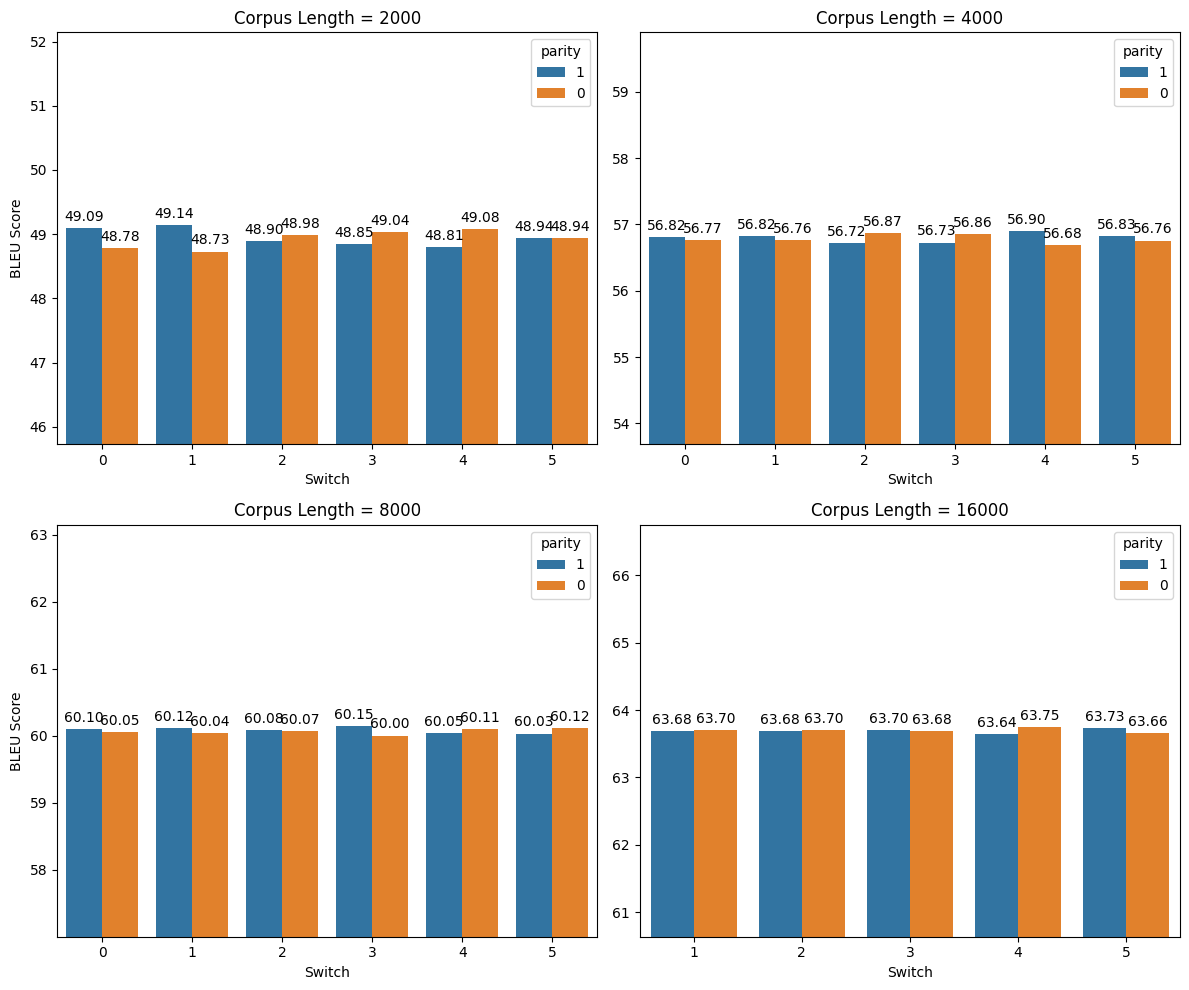

In [19]:
switches_barplot(switch_df, lengths=[2000,4000,8000,16000])

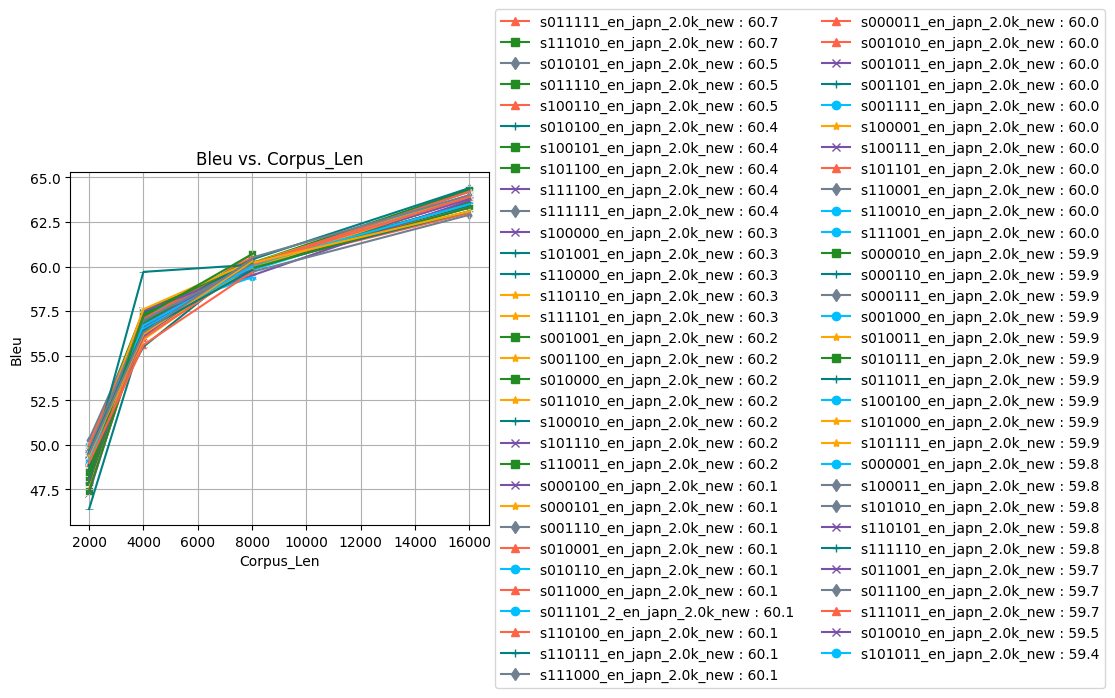

In [6]:
switches = df[(df['exp_name'] == 'new_switches') & (df['trained'])]
plot_scores(switches)

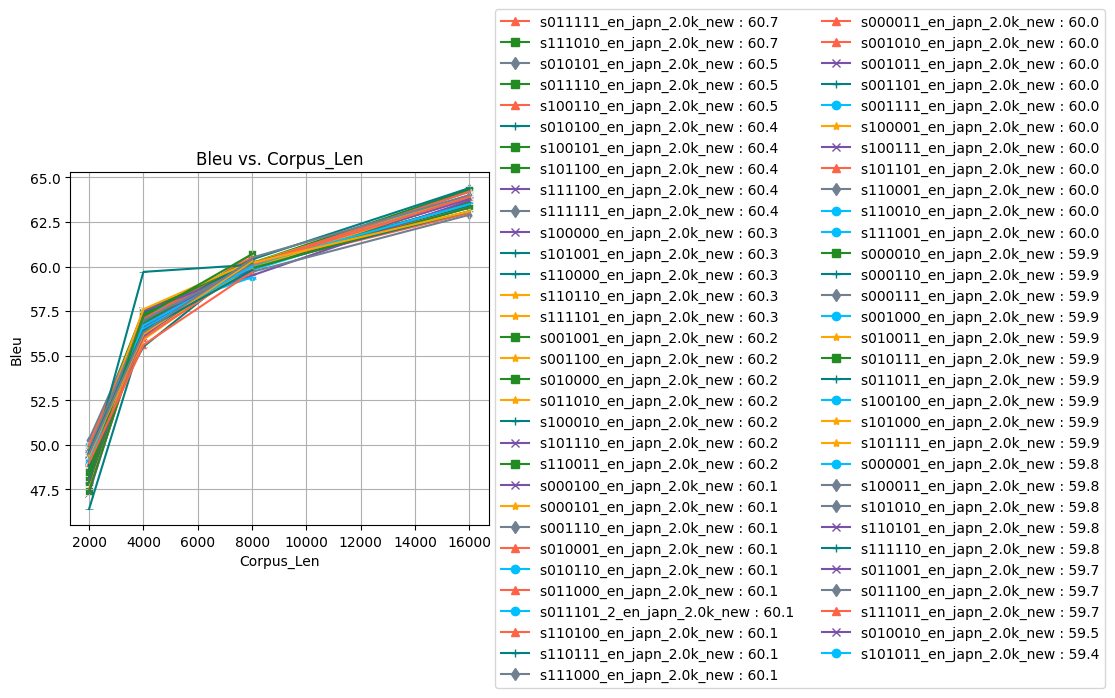

In [20]:
switches = df[(df['exp_name'] == 'new_switches') & (df['trained'])]
plot_switches(switches)

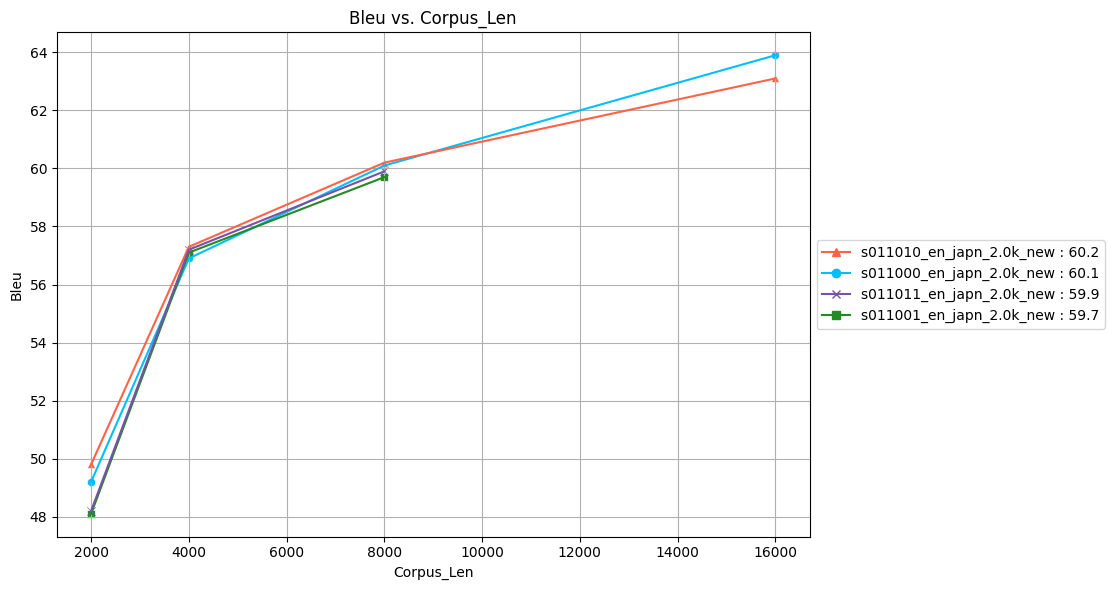

In [22]:
plot_switches(switches, condition='0110--')

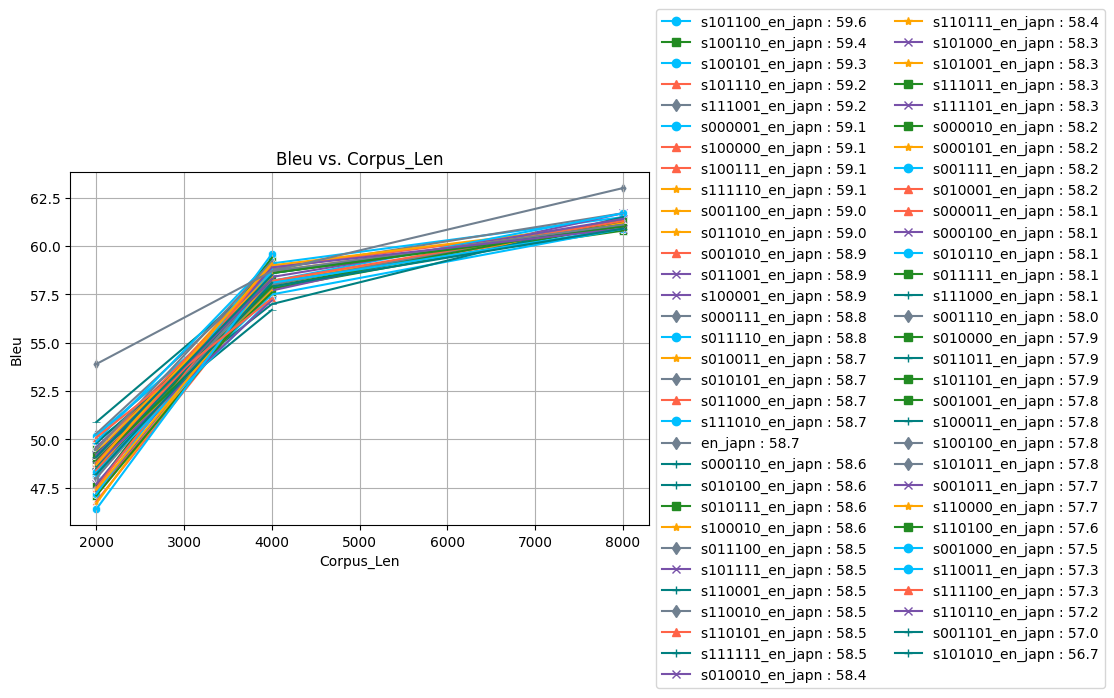

In [8]:
plot_switches(df)

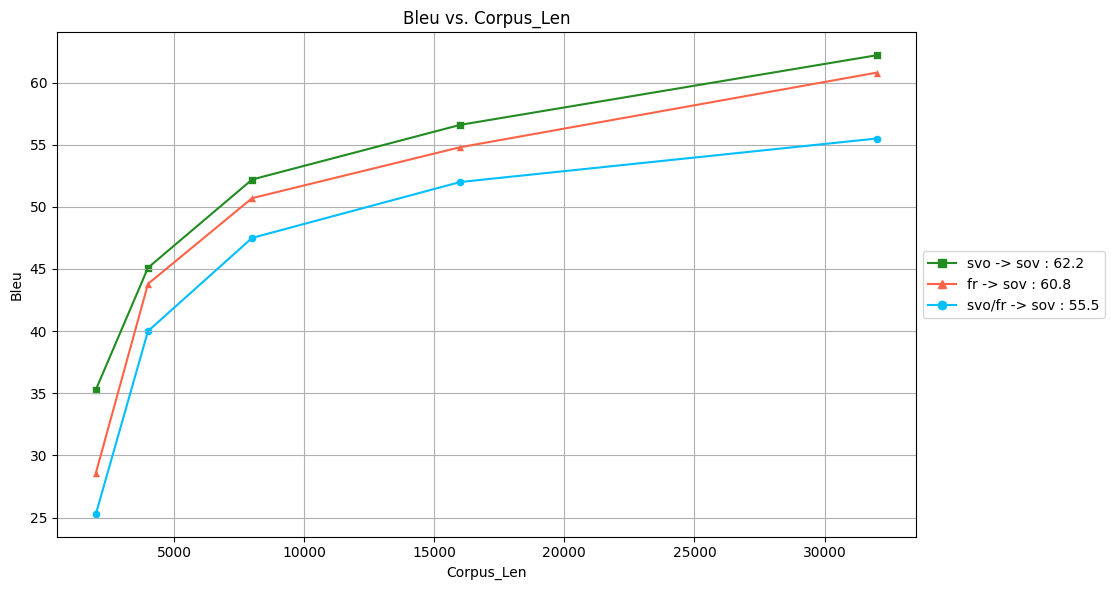

In [4]:
data = df[(df['trained']) & (df['exp_name'] == 'basic_multi')]

name_map = {
    "en_svo_en_sov" : 'svo -> sov',
    "en_svo_fr_en_sov" : 'svo/fr -> sov',
    'fr_en_sov'      : 'fr -> sov'
}

plot_scores(data, name_map=name_map)

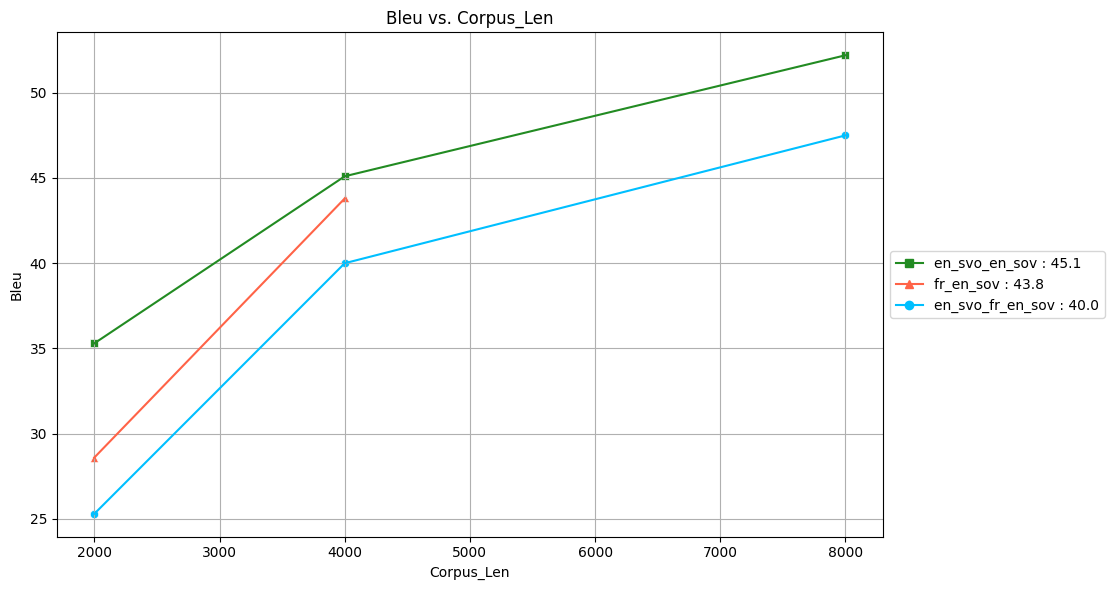

In [5]:
plot_scores(data)

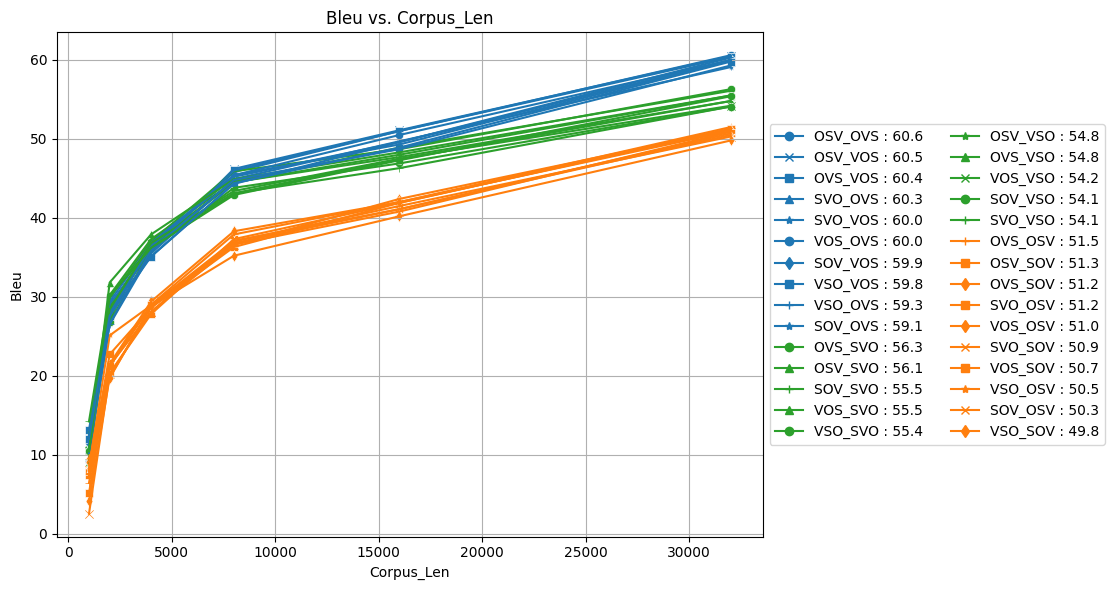

In [4]:
plot_desc = 'Plotting BLEU vs. corpus length for SVO perm experiment. Color coded by last letter of tgt language to highlight issue with BLEU as metric'
plot_scores(trained, color='last', savefig=True, filename='svo_perm_bleu', plot_desc=plot_desc)

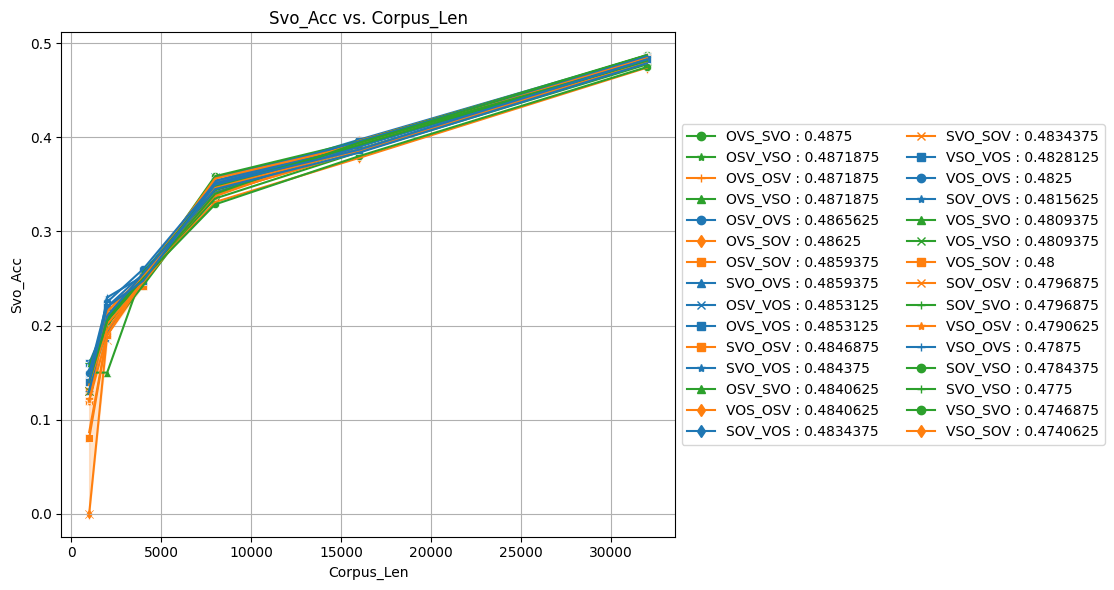

In [9]:
plot_desc = 'Plotting svo_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='svo_acc', color='last', savefig=True, filename='svo_perm_svo_acc', plot_desc=plot_desc)

The scores don't seem completely random (first letter, distance between letters, etc.)

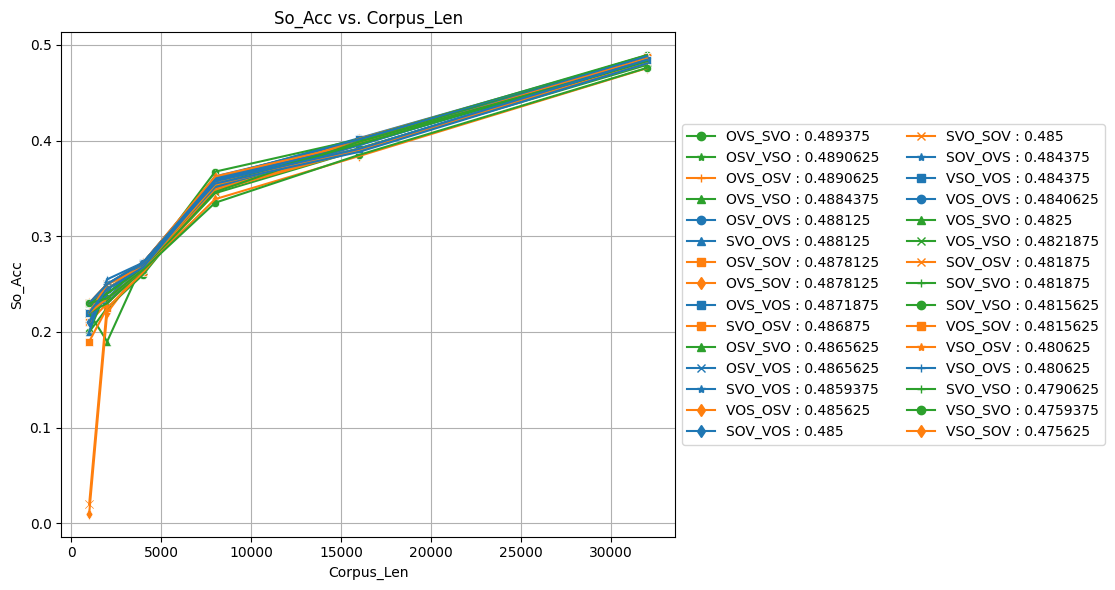

In [8]:
plot_scores(trained, score='so_acc', color='last')

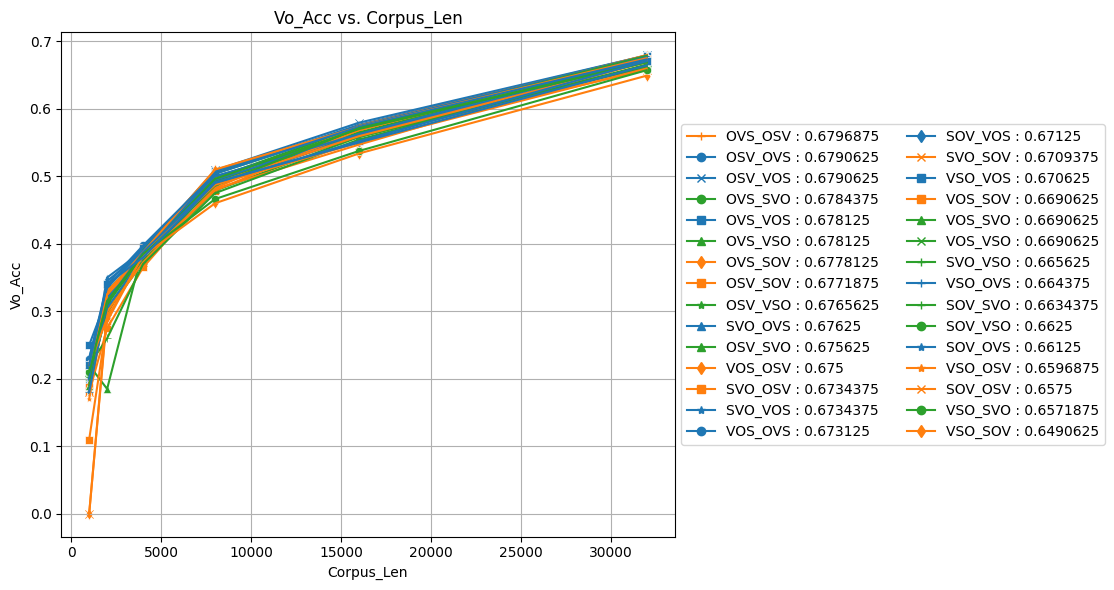

In [9]:
plot_scores(trained, score='vo_acc', color='last')

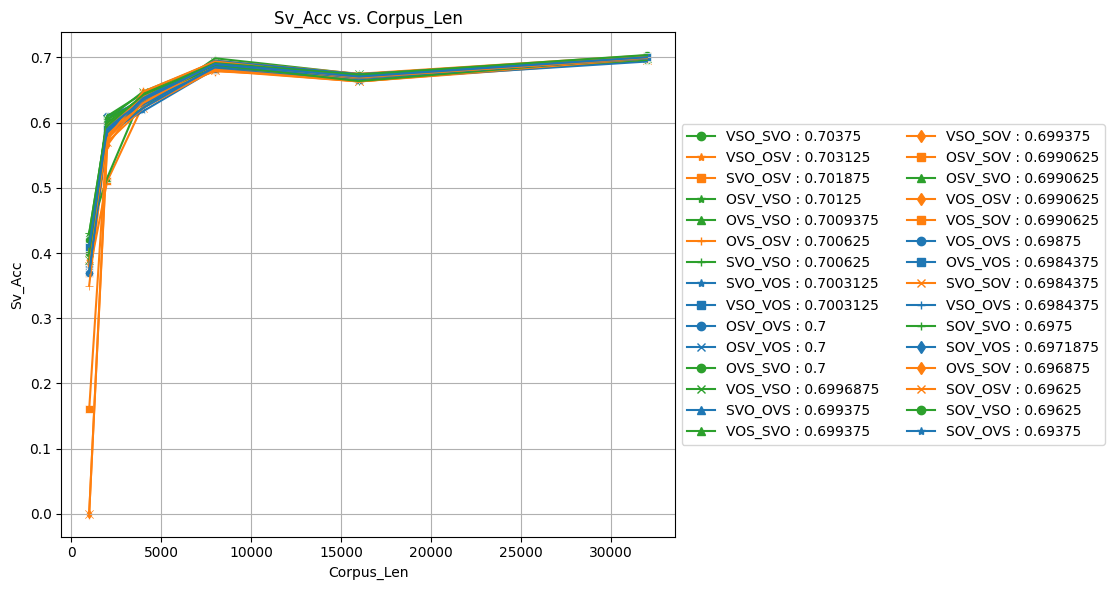

In [10]:
plot_scores(trained, score='sv_acc', color='last')

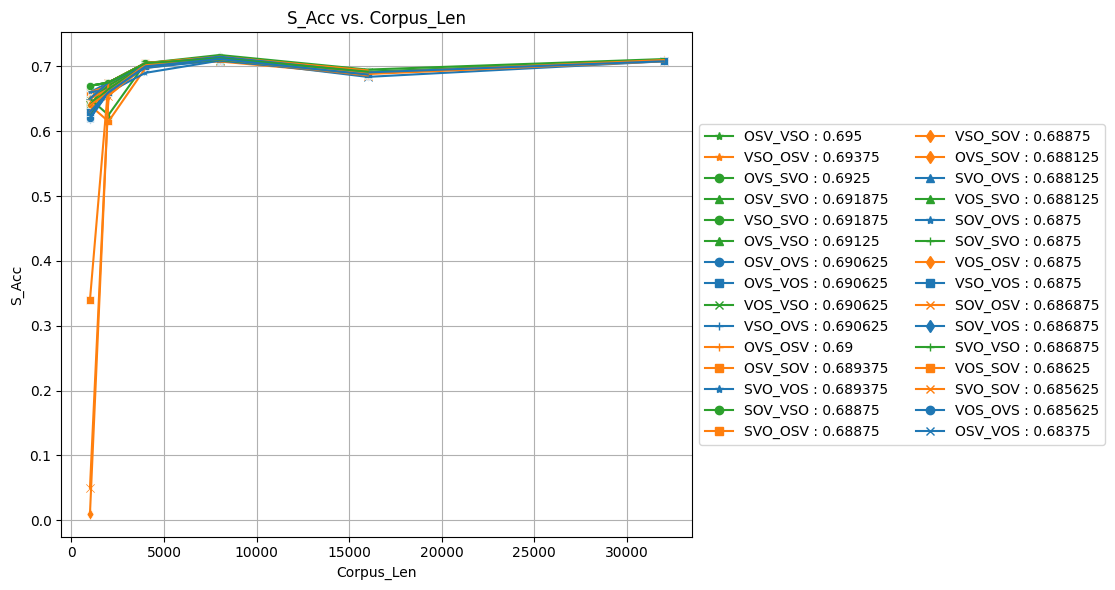

In [18]:
plot_scores(trained, score='s_acc', color='last')

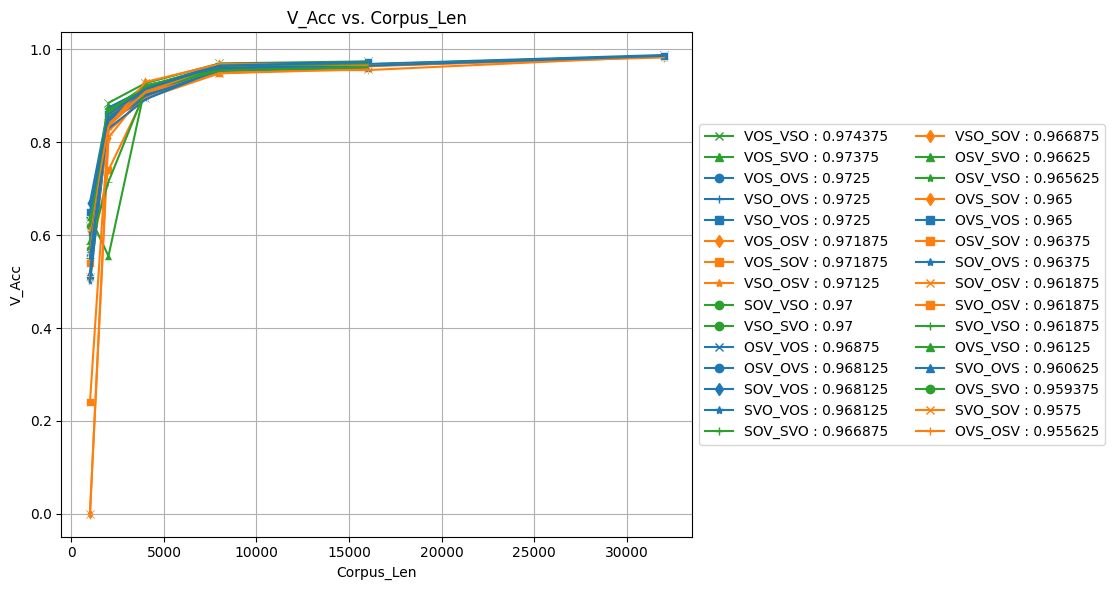

In [19]:
plot_scores(trained, score='v_acc', color='last')

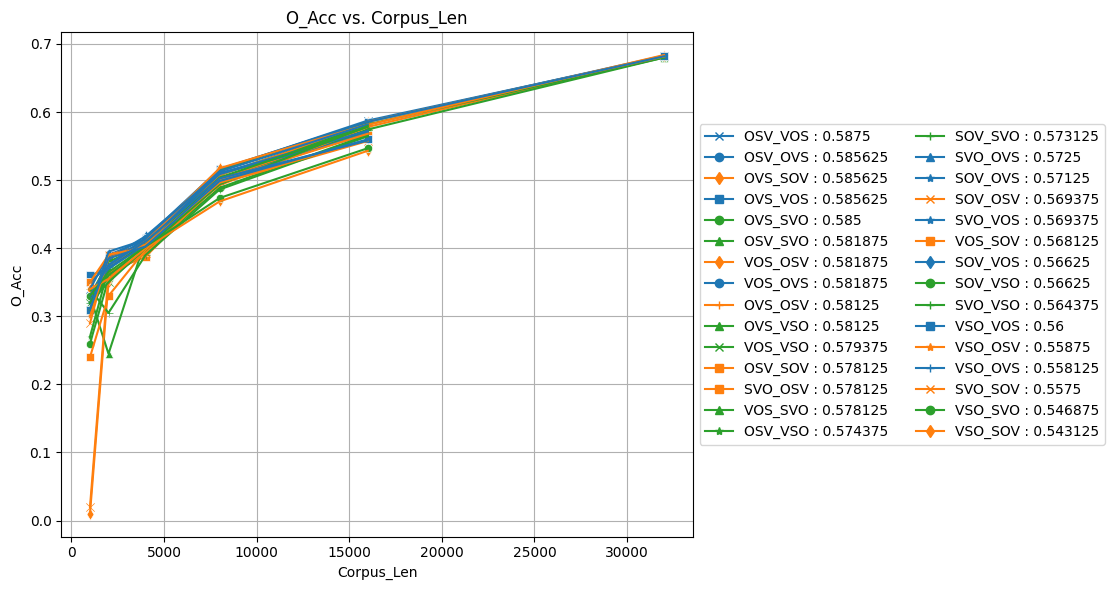

In [20]:
plot_scores(trained, score='o_acc', color='last')